# Vexpresso image vector db using CLIP

## In this walkthrough, we will be using a small dataset of Pokemon images and clip to embed

In [1]:
import json
import pandas as pd
from langchain.embeddings import HuggingFaceHubEmbeddings, HuggingFaceEmbeddings
import numpy as np
import daft
import vexpresso
from vexpresso import transformation
from vexpresso.retriever import NumpyRetriever

/home/shyam/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Lets look at the Data: from https://github.com/Purukitto/pokemon-data.json

In [2]:
with open("./data/pokedex.json", 'r') as f:
    stuff = json.load(f)

df = pd.DataFrame(stuff)

In [3]:
df.head(10)

,id,name,type,base,species,description,evolution,profile,image
0,1,"{'english': 'Bulbasaur', 'japanese': 'フシギダネ', ...","[Grass, Poison]","{'HP': 45, 'Attack': 49, 'Defense': 49, 'Sp. A...",Seed Pokémon,Bulbasaur can be seen napping in bright sunlig...,"{'next': [['2', 'Level 16']]}","{'height': '0.7 m', 'weight': '6.9 kg', 'egg':...",{'sprite': 'https://raw.githubusercontent.com/...
1,2,"{'english': 'Ivysaur', 'japanese': 'フシギソウ', 'c...","[Grass, Poison]","{'HP': 60, 'Attack': 62, 'Defense': 63, 'Sp. A...",Seed Pokémon,There is a bud on this Pokémon’s back. To supp...,"{'prev': ['1', 'Level 16'], 'next': [['3', 'Le...","{'height': '1 m', 'weight': '13 kg', 'egg': ['...",{'sprite': 'https://raw.githubusercontent.com/...
2,3,"{'english': 'Venusaur', 'japanese': 'フシギバナ', '...","[Grass, Poison]","{'HP': 80, 'Attack': 82, 'Defense': 83, 'Sp. A...",Seed Pokémon,There is a large flower on Venusaur’s back. Th...,"{'prev': ['2', 'Level 32']}","{'height': '2 m', 'weight': '100 kg', 'egg': [...",{'sprite': 'https://raw.githubusercontent.com/...
3,4,"{'english': 'Charmander', 'japanese': 'ヒトカゲ', ...",[Fire],"{'HP': 39, 'Attack': 52, 'Defense': 43, 'Sp. A...",Lizard Pokémon,The flame that burns at the tip of its tail is...,"{'next': [['5', 'Level 16']]}","{'height': '0.6 m', 'weight': '8.5 kg', 'egg':...",{'sprite': 'https://raw.githubusercontent.com/...
4,5,"{'english': 'Charmeleon', 'japanese': 'リザード', ...",[Fire],"{'HP': 58, 'Attack': 64, 'Defense': 58, 'Sp. A...",Flame Pokémon,Charmeleon mercilessly destroys its foes using...,"{'prev': ['4', 'Level 16'], 'next': [['6', 'Le...","{'height': '1.1 m', 'weight': '19 kg', 'egg': ...",{'sprite': 'https://raw.githubusercontent.com/...
5,6,"{'english': 'Charizard', 'japanese': 'リザードン', ...","[Fire, Flying]","{'HP': 78, 'Attack': 84, 'Defense': 78, 'Sp. A...",Flame Pokémon,Charizard flies around the sky in search of po...,"{'prev': ['5', 'Level 36']}","{'height': '1.7 m', 'weight': '90.5 kg', 'egg'...",{'sprite': 'https://raw.githubusercontent.com/...
6,7,"{'english': 'Squirtle', 'japanese': 'ゼニガメ', 'c...",[Water],"{'HP': 44, 'Attack': 48, 'Defense': 65, 'Sp. A...",Tiny Turtle Pokémon,Squirtle’s shell is not merely used for protec...,"{'next': [['8', 'Level 16']]}","{'height': '0.5 m', 'weight': '9 kg', 'egg': [...",{'sprite': 'https://raw.githubusercontent.com/...
7,8,"{'english': 'Wartortle', 'japanese': 'カメール', '...",[Water],"{'HP': 59, 'Attack': 63, 'Defense': 80, 'Sp. A...",Turtle Pokémon,"Its tail is large and covered with a rich, thi...","{'prev': ['7', 'Level 16'], 'next': [['9', 'Le...","{'height': '1 m', 'weight': '22.5 kg', 'egg': ...",{'sprite': 'https://raw.githubusercontent.com/...
8,9,"{'english': 'Blastoise', 'japanese': 'カメックス', ...",[Water],"{'HP': 79, 'Attack': 83, 'Defense': 100, 'Sp. ...",Shellfish Pokémon,Blastoise has water spouts that protrude from ...,"{'prev': ['8', 'Level 36']}","{'height': '1.6 m', 'weight': '85.5 kg', 'egg'...",{'sprite': 'https://raw.githubusercontent.com/...
9,10,"{'english': 'Caterpie', 'japanese': 'キャタピー', '...",[Bug],"{'HP': 45, 'Attack': 30, 'Defense': 35, 'Sp. A...",Worm Pokémon,"Its body is soft and weak. In nature, its perp...","{'next': [['11', 'Level 7']]}","{'height': '0.3 m', 'weight': '2.9 kg', 'egg':...",{'sprite': 'https://raw.githubusercontent.com/...


#### Because this is a simple example, lets only use the first 151 Pokemon

In [4]:
df = df.iloc[:151]

In [5]:
df.iloc[0]["image"]

{'sprite': 'https://raw.githubusercontent.com/Purukitto/pokemon-data.json/master/images/pokedex/sprites/001.png',
 'thumbnail': 'https://raw.githubusercontent.com/Purukitto/pokemon-data.json/master/images/pokedex/thumbnails/001.png',
 'hires': 'https://raw.githubusercontent.com/Purukitto/pokemon-data.json/master/images/pokedex/hires/001.png'}

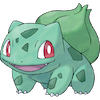

In [6]:
from PIL import Image
import requests

im = Image.open(requests.get("https://raw.githubusercontent.com/Purukitto/pokemon-data.json/master/images/pokedex/thumbnails/001.png", stream=True).raw)
im

### Super simple download function!

In [7]:
@transformation
def download_images(images, image_type):
    return [Image.open(requests.get(im["thumbnail"], stream=True).raw).convert(image_type) for im in images]

### Create the collection, and use a custom transformation function to download images.

In [8]:
collection = vexpresso.create(
    data=df,
)

2023-06-05 18:41:32.886 | INFO     | daft.context:runner:88 - Using PyRunner



#### For the call below, we want to pass in the image dictionaries in the column `image`, but we also want to specify `image_type` to be RGB

In [9]:
collection = collection.apply(download_images, collection["image"], image_type="RGB", to="downloaded_image").execute()

In [10]:
collection.show(5)

idInt64,"nameStruct[chinese: Utf8, english: Utf8, french: Utf8, japanese: Utf8]",typeList[Utf8],"baseStruct[Attack: Int64, Defense: Int64, HP: Int64, Sp. Attack: Int64, Sp. Defense: Int64, Speed: Int64]",speciesUtf8,descriptionUtf8,"evolutionStruct[next: List[List[Utf8]], prev: List[Utf8]]","profileStruct[ability: List[List[Utf8]], egg: List[Utf8], gender: Utf8, height: Utf8, weight: Utf8]","imageStruct[hires: Utf8, sprite: Utf8, thumbnail: Utf8]",vexpresso_indexInt64
1,"{'chinese': '妙蛙种子', 'english': 'Bulbasaur', 'french': 'Bu...","['Grass', 'Poison']","{'Attack': 49, 'Defense': 49, 'HP': 45, 'Sp. Attack': 65,...",Seed Pokémon,Bulbasaur can be seen napping in bright sunlight. There i...,"{'next': [['2', 'Level 16']], 'prev': None}","{'ability': [['Overgrow', 'false'], ['Chlorophyll', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,0
2,"{'chinese': '妙蛙草', 'english': 'Ivysaur', 'french': 'Herbi...","['Grass', 'Poison']","{'Attack': 62, 'Defense': 63, 'HP': 60, 'Sp. Attack': 80,...",Seed Pokémon,There is a bud on this Pokémon’s back. To support its wei...,"{'next': [['3', 'Level 32']], 'prev': ['1', 'Level 16']}","{'ability': [['Overgrow', 'false'], ['Chlorophyll', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,1
3,"{'chinese': '妙蛙花', 'english': 'Venusaur', 'french': 'Flor...","['Grass', 'Poison']","{'Attack': 82, 'Defense': 83, 'HP': 80, 'Sp. Attack': 100...",Seed Pokémon,There is a large flower on Venusaur’s back. The flower is...,"{'next': None, 'prev': ['2', 'Level 32']}","{'ability': [['Overgrow', 'false'], ['Chlorophyll', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,2
4,"{'chinese': '小火龙', 'english': 'Charmander', 'french': 'Sa...",['Fire'],"{'Attack': 52, 'Defense': 43, 'HP': 39, 'Sp. Attack': 60,...",Lizard Pokémon,The flame that burns at the tip of its tail is an indicat...,"{'next': [['5', 'Level 16']], 'prev': None}","{'ability': [['Blaze', 'false'], ['Solar Power', 'true']]...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,3
5,"{'chinese': '火恐龙', 'english': 'Charmeleon', 'french': 'Re...",['Fire'],"{'Attack': 64, 'Defense': 58, 'HP': 58, 'Sp. Attack': 80,...",Flame Pokémon,Charmeleon mercilessly destroys its foes using its sharp ...,"{'next': [['6', 'Level 36']], 'prev': ['4', 'Level 16']}","{'ability': [['Blaze', 'false'], ['Solar Power', 'true']]...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,4


### Lets use a multimodal Clip Embeddings model to query images, implemented as a simple function

In [11]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

@transformation
def clip_embeddings_fn(inp, inp_type):
    if inp_type == "image":
        inputs = processor(images=inp, return_tensors="pt", padding=True)
        return model.get_image_features(**inputs).detach().cpu().numpy()
    if inp_type == "text":
        inputs = processor(text=inp, return_tensors="pt", padding=True)
        return model.get_text_features(**inputs).detach().cpu().numpy()

In [ ]:
collection = collection.embed("downloaded_image", embedding_fn=clip_embeddings_fn, inp_type="image", to="image_embeddings").execute()

#### This can also be done with the `apply` function

In [ ]:
collection = collection.apply(clip_embeddings_fn, collection["downloaded_image"], inp_type="image", to="image_embeddings").execute()

In [ ]:
collection.show(5)

### Query Images with text

#### Querying for red pokemon

In [ ]:
red_pokemon = collection.query("image_embeddings", query=["Fire Pokemon that has red and orange skin and looks like a lizard"], k=10, inp_type="text") \
                        .execute()
red_pokemon.show(5)

In [ ]:
red_pokemon = collection.query("image_embeddings", ["Fire Pokemon that has red and orange skin and looks like a lizard"], k=10, inp_type="text") \
                        .filter({"base.Attack":{"gte":60}}) \
                        .execute()
red_pokemon.show(5)

#### Querying for pokemon that look like plants

In [ ]:
plant_pokemon = collection.query("image_embeddings", query=["Pokemon that looks like a plant"], k=10, inp_type="text") \
                        .execute()
plant_pokemon.show(5)

#### Querying for Plant pokemon, but filtering out Bug pokemon

##### We can use a custom filter or the built in `notcontains` method!

```python
# using custom filter
def filter_by_type(typ, avoid_type):
    return avoid_type not in typ

filter_condition = {
    "type": {
        "custom": (filter_by_type, {"avoid_type":"Bug"})
    }
}
```

In [ ]:
filter_condition = {
    "type": {
        "notcontains": "Bug"
    }
}

In [ ]:
plant_pokemon = collection.query(
    "image_embeddings",
    query=["Pokemon that looks like a plant"],
    k=10,
    inp_type="text",
    filter_conditions=filter_condition
)
plant_pokemon.show(5)

### Averaging text and image embeddings

In [ ]:
collection = collection.embed("description", embedding_fn=clip_embeddings_fn, inp_type="text", to="text_embeddings").execute()

In [ ]:
collection.show(10)

In [ ]:
@transformation
def combine_embeddings(text_embeddings, image_embeddings, text_embedding_weight = 0.25, image_embeddings_weight = 0.75):
    text_embeddings = np.stack(text_embeddings)
    image_embeddings = np.stack(image_embeddings)
    averaged = text_embedding_weight*text_embeddings + image_embeddings_weight*image_embeddings
    return [average for average in averaged]

In [ ]:
collection = collection.apply(
    combine_embeddings,
    collection["text_embeddings"],
    collection["image_embeddings"],
    text_embedding_weight=0.25,
    image_embeddings_weight=0.75,
    to="combined_embeddings"
).execute()

In [ ]:
red_pokemon = collection.query(
                        "combined_embeddings",
                        query=["Fire Pokemon that has red and orange skin and looks like a lizard"],
                        k=10,
                        inp_type="text",
                        embedding_fn=clip_embeddings_fn
                    ).execute()
red_pokemon.show(5)